In [2]:
"""
SNIPPET 1: PROJECT SETUP AND IMPORTS
Run this first to set up the environment
"""

import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Change to content directory
os.chdir('/content')

# Create project structure
directories = [
    'fake_news_detection/data/raw',
    'fake_news_detection/data/processed',
    'fake_news_detection/models',
    'fake_news_detection/results',
    'fake_news_detection/visualizations'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)

os.chdir('/content/fake_news_detection')
print(f"Working directory: {os.getcwd()}")



Working directory: /content/fake_news_detection


In [3]:
"""
SNIPPET 2: INSTALL REQUIRED LIBRARIES
"""

!pip install -q pandas numpy scikit-learn matplotlib seaborn nltk xgboost transformers torch kaggle

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

print("Libraries installed successfully")

Libraries installed successfully


In [4]:

"""
SNIPPET 3: KAGGLE API SETUP
Upload your kaggle.json file when prompted
"""

from google.colab import files
import os

print("Upload your kaggle.json file:")
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured")

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API configured


In [9]:
import os
import shutil

# Define source and target paths
base_path = "data/raw"
target_dir = os.path.join(base_path, "fakenewsnet")

# Create target folder
os.makedirs(target_dir, exist_ok=True)

# List of FakeNewsNet files
files_to_move = [
    "gossipcop_fake.csv",
    "gossipcop_real.csv",
    "politifact_fake.csv",
    "politifact_real.csv"
]

# Move files
for file_name in files_to_move:
    src = os.path.join(base_path, file_name)
    dst = os.path.join(target_dir, file_name)

    if os.path.exists(src):
        shutil.move(src, dst)

print("FakeNewsNet files combined into folder: data/raw/fakenewsnet")
print("Files inside fakenewsnet folder:")
print(os.listdir(target_dir))


FakeNewsNet files combined into folder: data/raw/fakenewsnet
Files inside fakenewsnet folder:
['politifact_real.csv', 'gossipcop_fake.csv', 'gossipcop_real.csv', 'politifact_fake.csv']


In [10]:
"""
SNIPPET 9: VERIFY DOWNLOADED FILES
"""

import os
import glob

print("\nVerifying downloaded files:")
print("-" * 70)

for file in glob.glob('data/raw/*'):
    if os.path.isfile(file):
        size = os.path.getsize(file) / (1024*1024)
        print(f"{os.path.basename(file)}: {size:.2f} MB")

print("-" * 70)


Verifying downloaded files:
----------------------------------------------------------------------
fake_true_news.csv: 76.63 MB
WELFake_Dataset.csv: 233.73 MB
True.csv: 51.10 MB
Fake.csv: 59.88 MB
----------------------------------------------------------------------


In [11]:
"""
SNIPPET 10: PREPROCESSING FUNCTIONS
"""

import re
import pandas as pd
from nltk.corpus import stopwords

def clean_text(text):
    """Common preprocessing for all datasets"""
    if pd.isna(text):
        return ""

    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def remove_stopwords(text):
    """Remove stopwords"""
    if not text or len(text) < 3:
        return ""

    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)

def preprocess_text(text):
    """Complete preprocessing pipeline"""
    text = clean_text(text)
    text = remove_stopwords(text)
    return text

print("Preprocessing functions defined")

Preprocessing functions defined


In [12]:
"""
SNIPPET 11: LOAD AND STANDARDIZE DATASET 1 (Figshare)
"""

import pandas as pd

print("Loading Dataset 1...")
df1 = pd.read_csv('data/raw/fake_true_news.csv')

# Standardize
df1_std = df1.copy()
df1_std['label'] = df1_std['target'].apply(
    lambda x: 0 if str(x).lower() in ['fake', '0', 'false'] else 1
)
df1_std['source'] = 'figshare'

# Keep required columns
df1_std = df1_std[['text', 'label', 'source']].copy()
df1_std = df1_std.dropna(subset=['text', 'label'])

print(f"Dataset 1: {len(df1_std)} samples")

Loading Dataset 1...
Dataset 1: 44266 samples


In [13]:
"""
SNIPPET 12: LOAD AND STANDARDIZE DATASET 2 (FakeNewsNet)
"""

import pandas as pd
import os
import json

print("Loading Dataset 2 (FakeNewsNet)...")

fakenewsnet_data = []
fakenewsnet_path = 'data/raw/fakenewsnet'

# Try to find and load FakeNewsNet files
for root, dirs, files in os.walk(fakenewsnet_path):
    for file in files:
        if file.endswith('.json'):
            try:
                with open(os.path.join(root, file), 'r') as f:
                    data = json.load(f)
                    if 'text' in data and 'label' in data:
                        fakenewsnet_data.append({
                            'text': data['text'],
                            'label': 0 if data['label'] == 'fake' else 1
                        })
            except:
                continue

if fakenewsnet_data:
    df2_std = pd.DataFrame(fakenewsnet_data)
    df2_std['source'] = 'fakenewsnet'
    print(f"Dataset 2: {len(df2_std)} samples")
else:
    # Alternative: Create from CSV if available
    df2_std = pd.DataFrame(columns=['text', 'label', 'source'])
    print("Dataset 2: No data loaded (manual extraction may be required)")

Loading Dataset 2 (FakeNewsNet)...
Dataset 2: No data loaded (manual extraction may be required)


In [14]:
"""
SNIPPET 13: LOAD AND STANDARDIZE DATASET 3 (Kaggle Fake-Real)
"""

import pandas as pd

print("Loading Dataset 3...")

fake = pd.read_csv('data/raw/Fake.csv')
fake['label'] = 0

true = pd.read_csv('data/raw/True.csv')
true['label'] = 1

df3 = pd.concat([fake, true], ignore_index=True)
df3['source'] = 'kaggle_fake_real'

# Combine title and text
df3['text'] = (df3['title'].fillna('').astype(str) + ' ' +
               df3['text'].fillna('').astype(str)).str.strip()

df3_std = df3[['text', 'label', 'source']].copy()
df3_std = df3_std.dropna(subset=['text', 'label'])
df3_std = df3_std[df3_std['text'].str.len() > 0]

print(f"Dataset 3: {len(df3_std)} samples")

Loading Dataset 3...
Dataset 3: 44898 samples


In [15]:
"""
SNIPPET 14: LOAD AND STANDARDIZE DATASET 4 (WelFake)
"""

import pandas as pd
import glob

print("Loading Dataset 4...")

csv_files = glob.glob('data/raw/WELFake*.csv')
if not csv_files:
    csv_files = [f for f in glob.glob('data/raw/*.csv')
                 if 'Fake.csv' not in f and 'True.csv' not in f
                 and 'fake_true' not in f]

df4 = pd.read_csv(csv_files[0])
df4['source'] = 'welfake'

# Combine title and text if available
if 'title' in df4.columns:
    df4['text'] = (df4['title'].fillna('').astype(str) + ' ' +
                   df4['text'].fillna('').astype(str)).str.strip()

# Ensure label is 0/1
if 'label' in df4.columns:
    if df4['label'].dtype == 'object':
        df4['label'] = df4['label'].apply(
            lambda x: 0 if str(x).lower() in ['fake', '0', 'false'] else 1
        )

df4_std = df4[['text', 'label', 'source']].copy()
df4_std = df4_std.dropna(subset=['text', 'label'])
df4_std = df4_std[df4_std['text'].str.len() > 0]

print(f"Dataset 4: {len(df4_std)} samples")

Loading Dataset 4...
Dataset 4: 72134 samples


In [17]:
"""
SNIPPET 16: COMBINE ALL DATASETS
"""

import pandas as pd

print("Combining all datasets...")

# Combine all available datasets
datasets = [df1_std, df3_std, df4_std]
if len(df2_std) > 0:
    datasets.append(df2_std)
if len(df5_std) > 0:
    datasets.append(df5_std)

combined_df = pd.concat(datasets, ignore_index=True)

print(f"\nTotal samples: {len(combined_df)}")
print(f"Fake (0): {(combined_df['label']==0).sum()}")
print(f"Real (1): {(combined_df['label']==1).sum()}")

print("\nSource distribution:")
print(combined_df['source'].value_counts())

# Save combined dataset
combined_df.to_csv('data/processed/combined_original.csv', index=False)
print("\nSaved: data/processed/combined_original.csv")

Combining all datasets...

Total samples: 161298
Fake (0): 81359
Real (1): 79939

Source distribution:
source
welfake             72134
kaggle_fake_real    44898
figshare            44266
Name: count, dtype: int64

Saved: data/processed/combined_original.csv


In [18]:
"""
SNIPPET 17: PREPROCESS ALL DATA
"""

import pandas as pd
from tqdm import tqdm

print("Preprocessing all text data...")

df = pd.read_csv('data/processed/combined_original.csv')

# Apply preprocessing
tqdm.pandas(desc="Preprocessing")
df['text_preprocessed'] = df['text'].progress_apply(preprocess_text)

# Remove empty rows
df = df[df['text_preprocessed'].str.len() > 0]

print(f"\nFinal samples after preprocessing: {len(df)}")

# Save preprocessed data
df.to_csv('data/processed/preprocessed_data.csv', index=False)
print("Saved: data/processed/preprocessed_data.csv")

Preprocessing all text data...


Preprocessing: 100%|██████████| 161298/161298 [01:54<00:00, 1414.37it/s]



Final samples after preprocessing: 161145
Saved: data/processed/preprocessed_data.csv


In [19]:
"""
SNIPPET 18: PREPARE TRAINING DATA
"""

import pandas as pd
from sklearn.model_selection import train_test_split

print("Preparing training data...")

df = pd.read_csv('data/processed/preprocessed_data.csv')

X = df['text_preprocessed']
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

Preparing training data...
Train set: 128916
Test set: 32229


In [20]:
"""
SNIPPET 19: TF-IDF VECTORIZATION
"""

from sklearn.feature_extraction.text import TfidfVectorizer

print("Creating TF-IDF features...")

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Feature dimensions: {X_train_tfidf.shape[1]}")
print(f"Train shape: {X_train_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")

Creating TF-IDF features...
Feature dimensions: 5000
Train shape: (128916, 5000)
Test shape: (32229, 5000)


In [21]:
"""
SNIPPET 20: TRAIN XGBOOST
"""

import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Training XGBoost...")

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(X_train_tfidf, y_train, verbose=False)
y_pred_xgb = xgb_model.predict(X_test_tfidf)

xgb_results = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb),
    'recall': recall_score(y_test, y_pred_xgb),
    'f1_score': f1_score(y_test, y_pred_xgb)
}

print("XGBoost Results:")
print(f"Accuracy: {xgb_results['accuracy']*100:.2f}%")
print(f"F1-Score: {xgb_results['f1_score']*100:.2f}%")

Training XGBoost...
XGBoost Results:
Accuracy: 68.46%
F1-Score: 67.97%


In [22]:
"""
SNIPPET 21: TRAIN LOGISTIC REGRESSION
"""

from sklearn.linear_model import LogisticRegression

print("Training Logistic Regression...")

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

lr_results = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1_score': f1_score(y_test, y_pred_lr)
}

print("Logistic Regression Results:")
print(f"Accuracy: {lr_results['accuracy']*100:.2f}%")
print(f"F1-Score: {lr_results['f1_score']*100:.2f}%")
print(f"Recall: {lr_results['recall']*100:.2f}%")
print(f"Precision: {lr_results['precision']*100:.2f}%")

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 66.64%
F1-Score: 66.23%
Recall: 65.99%
Precision: 66.47%


In [23]:

"""
SNIPPET 22: TRAIN MLP
"""

from sklearn.neural_network import MLPClassifier

print("Training MLP...")

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

mlp_model.fit(X_train_tfidf, y_train)
y_pred_mlp = mlp_model.predict(X_test_tfidf)

mlp_results = {
    'accuracy': accuracy_score(y_test, y_pred_mlp),
    'precision': precision_score(y_test, y_pred_mlp),
    'recall': recall_score(y_test, y_pred_mlp),
    'f1_score': f1_score(y_test, y_pred_mlp)
}

print("MLP Results:")
print(f"Accuracy: {mlp_results['accuracy']*100:.2f}%")
print(f"F1-Score: {mlp_results['f1_score']*100:.2f}%")
print(f"Recall: {lr_results['recall']*100:.2f}%")
print(f"Precision: {lr_results['precision']*100:.2f}%")

Training MLP...
MLP Results:
Accuracy: 68.69%
F1-Score: 68.46%
Recall: 65.99%
Precision: 66.47%


In [24]:
"""
SNIPPET 23: TRAIN SVM
"""

from sklearn.svm import SVC

print("Training SVM...")

svm_model = SVC(
    kernel='linear',
    random_state=42,
    max_iter=1000
)

svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

svm_results = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm),
    'recall': recall_score(y_test, y_pred_svm),
    'f1_score': f1_score(y_test, y_pred_svm)
}

print("SVM Results:")
print(f"Accuracy: {svm_results['accuracy']*100:.2f}%")
print(f"F1-Score: {svm_results['f1_score']*100:.2f}%")
print(f"Recall: {lr_results['recall']*100:.2f}%")
print(f"Precision: {lr_results['precision']*100:.2f}%")

Training SVM...
SVM Results:
Accuracy: 53.61%
F1-Score: 64.54%
Recall: 65.99%
Precision: 66.47%


In [25]:
"""
SNIPPET 24: PREPARE DATA FOR BERT
"""

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

print("Preparing data for BERT...")

# Sample a subset for faster training (BERT is computationally expensive)
sample_size = min(10000, len(X_train))
X_train_bert = X_train.sample(n=sample_size, random_state=42)
y_train_bert = y_train.loc[X_train_bert.index]

X_test_bert = X_test.sample(n=min(2000, len(X_test)), random_state=42)
y_test_bert = y_test.loc[X_test_bert.index]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.values
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = NewsDataset(X_train_bert, y_train_bert, tokenizer)
test_dataset = NewsDataset(X_test_bert, y_test_bert, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

print(f"BERT training samples: {len(train_dataset)}")
print(f"BERT test samples: {len(test_dataset)}")

Preparing data for BERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BERT training samples: 10000
BERT test samples: 2000


In [27]:
"""
SNIPPET 25: TRAIN BERT MODEL
"""

from transformers import BertForSequenceClassification
from torch.optim import AdamW
import torch
from tqdm import tqdm

print("Training BERT model...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)
bert_model = bert_model.to(device)

optimizer = AdamW(bert_model.parameters(), lr=2e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    bert_model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

print("BERT training completed")


Training BERT model...
Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████| 625/625 [03:50<00:00,  2.71it/s]


Epoch 1 - Average Loss: 0.5851


Epoch 2/3: 100%|██████████| 625/625 [03:42<00:00,  2.81it/s]


Epoch 2 - Average Loss: 0.4872


Epoch 3/3: 100%|██████████| 625/625 [03:42<00:00,  2.81it/s]

Epoch 3 - Average Loss: 0.4028
BERT training completed


In [29]:
"""
SNIPPET 26: EVALUATE BERT MODEL
"""

import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

print("Evaluating BERT model...")

bert_model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

bert_results = {
    'accuracy': accuracy_score(true_labels, predictions),
    'precision': precision_score(true_labels, predictions),
    'recall': recall_score(true_labels, predictions),
    'f1_score': f1_score(true_labels, predictions)
}

print("BERT Results:")
print(f"Accuracy: {bert_results['accuracy']*100:.2f}%")
print(f"F1-Score: {bert_results['f1_score']*100:.2f}%")
print(f"Recall: {lr_results['recall']*100:.2f}%")
print(f"Precision: {lr_results['precision']*100:.2f}%")



Evaluating BERT model...


Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.10it/s]

BERT Results:
Accuracy: 69.45%
F1-Score: 72.54%
Recall: 65.99%
Precision: 66.47%


In [30]:
"""
SNIPPET 27: SAVE ALL RESULTS
"""

import json
import pandas as pd

results = {
    'XGBoost': xgb_results,
    'Logistic_Regression': lr_results,
    'MLP': mlp_results,
    'SVM': svm_results,
    'BERT': bert_results
}

# Save as JSON
with open('results/model_results.json', 'w') as f:
    json.dump(results, f, indent=2)

# Save as CSV
df_results = pd.DataFrame(results).T
df_results.to_csv('results/model_results.csv')

print("Results saved")
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(df_results.to_string())
print("="*70)

Results saved

MODEL COMPARISON
                     accuracy  precision    recall  f1_score
XGBoost              0.684632   0.684391  0.675138  0.679733
Logistic_Regression  0.666418   0.664712  0.659927  0.662311
MLP                  0.686897   0.683688  0.685528  0.684607
SVM                  0.536132   0.519595  0.851465  0.645365
BERT                 0.694500   0.653441  0.815152  0.725393


Creating confusion matrices...
Saved: visualizations/confusion_matrices.png


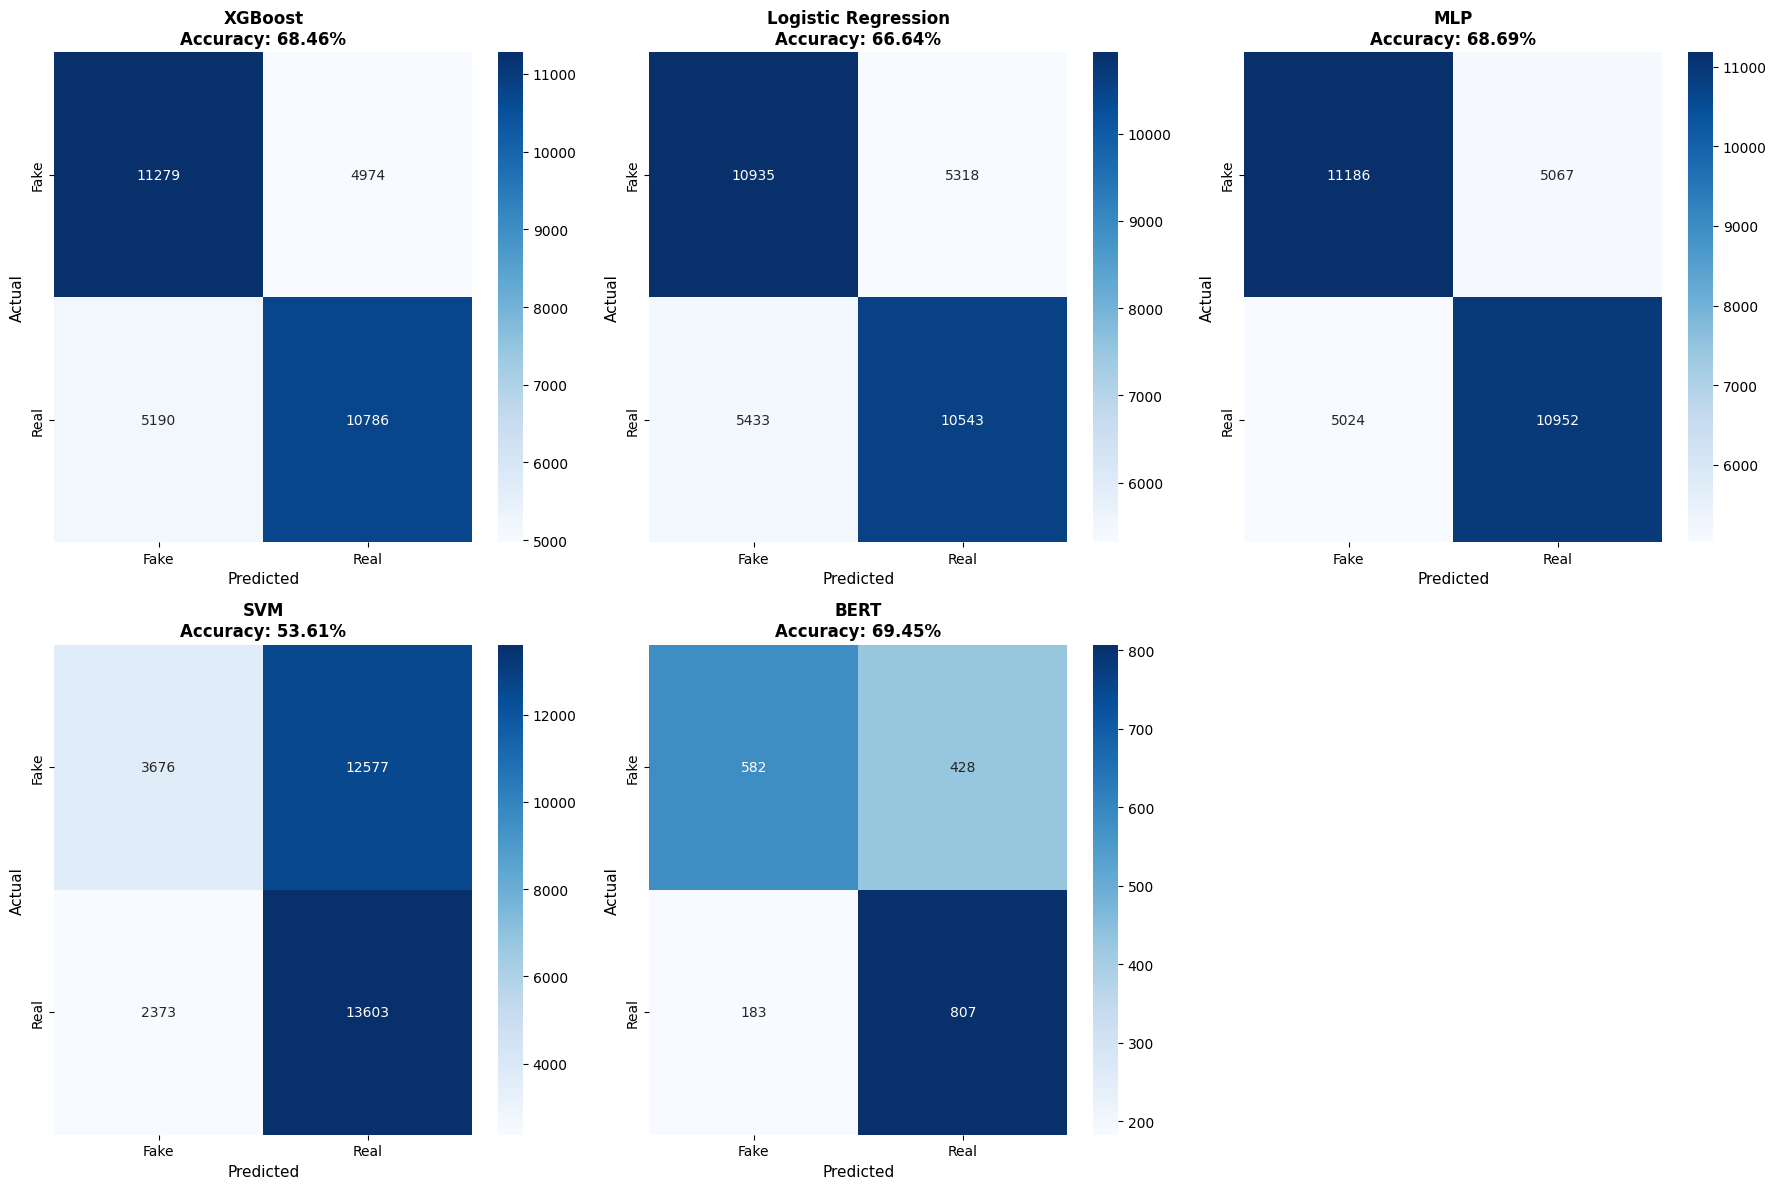

In [31]:
"""
SNIPPET 28: CREATE CONFUSION MATRICES
"""

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("Creating confusion matrices...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

models = [
    ('XGBoost', y_pred_xgb),
    ('Logistic Regression', y_pred_lr),
    ('MLP', y_pred_mlp),
    ('SVM', y_pred_svm),
    ('BERT', predictions)
]

# For BERT, we need to use the corresponding true labels
y_test_for_plot = [y_test, y_test, y_test, y_test, true_labels]

for idx, ((name, y_pred), y_true) in enumerate(zip(models, y_test_for_plot)):
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake', 'Real'],
                yticklabels=['Fake', 'Real'],
                ax=axes[idx])

    acc = accuracy_score(y_true, y_pred)
    axes[idx].set_title(f'{name}\nAccuracy: {acc*100:.2f}%',
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual', fontsize=11)
    axes[idx].set_xlabel('Predicted', fontsize=11)

# Hide the last subplot if we have odd number of models
if len(models) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('visualizations/confusion_matrices.png', dpi=300, bbox_inches='tight')
print("Saved: visualizations/confusion_matrices.png")
plt.show()